In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("castara-tobago.jpeg", "https://github.com/rajeevratan84/ModernComputerVision/raw/main/castara-tobago.jpeg")
result_prefix = "sky_dream"

layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}


step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 15.0

233568/233568 [==============================] - 0s 0us/step


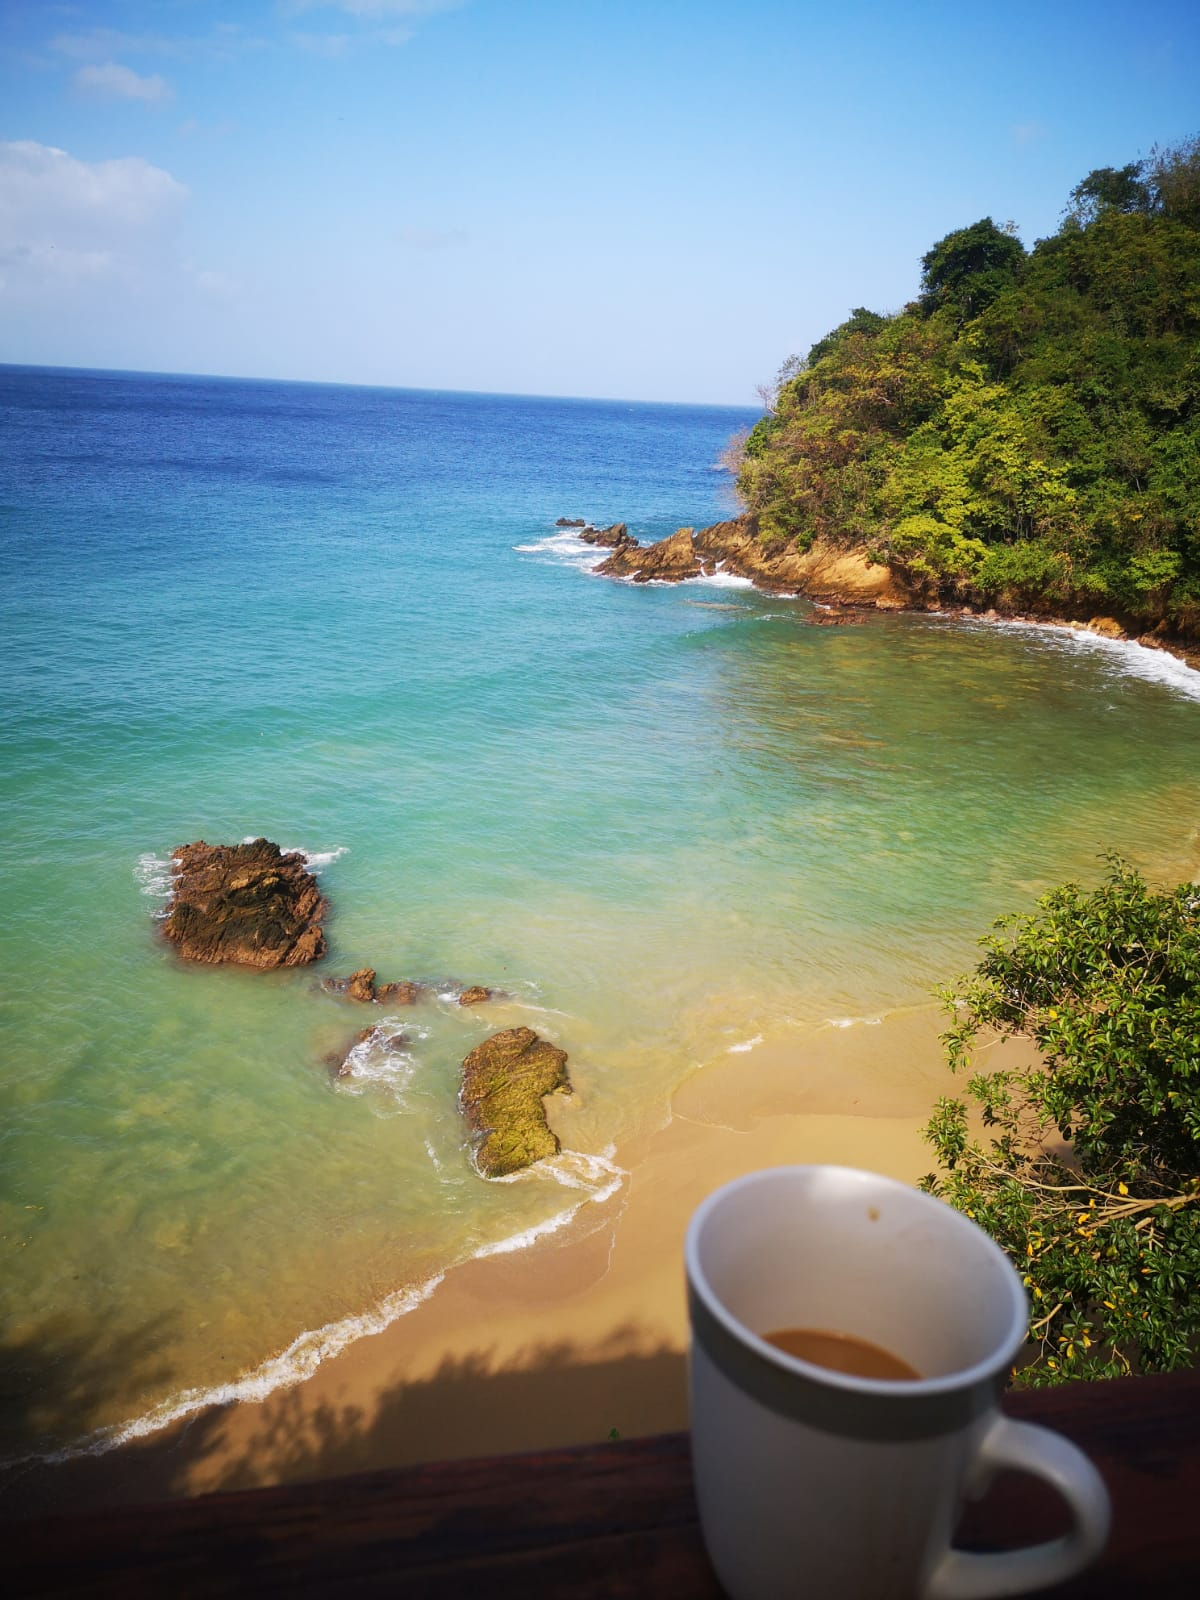

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))

In [ ]:
def preprocess_image(image_path):
    '''Util function to open, resize and format pictures
     into appropriate arrays.'''
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    '''Util function to convert a NumPy array into a valid image.'''
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.0
    x += 0.5
    x *= 255.0
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)


outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)


feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    ''' Initialize the loss '''
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

In [ ]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    grads = tape.gradient(loss, img)
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

In [ ]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (816, 612)
... Loss value at step 0: 0.60
... Loss value at step 1: 0.77
... Loss value at step 2: 1.00
... Loss value at step 3: 1.26
... Loss value at step 4: 1.49
... Loss value at step 5: 1.76
... Loss value at step 6: 2.00
... Loss value at step 7: 2.22
... Loss value at step 8: 2.42
... Loss value at step 9: 2.68
... Loss value at step 10: 2.89
... Loss value at step 11: 3.11
... Loss value at step 12: 3.37
... Loss value at step 13: 3.58
... Loss value at step 14: 3.85
... Loss value at step 15: 3.99
... Loss value at step 16: 4.26
... Loss value at step 17: 4.46
... Loss value at step 18: 4.69
... Loss value at step 19: 4.82
Processing octave 1 with shape (1142, 857)
... Loss value at step 0: 1.14
... Loss value at step 1: 1.82
... Loss value at step 2: 2.21
... Loss value at step 3: 2.60
... Loss value at step 4: 2.91
... Loss value at step 5: 3.26
... Loss value at step 6: 3.52
... Loss value at step 7: 3.84
... Loss value at step 8: 4.11
... Lo

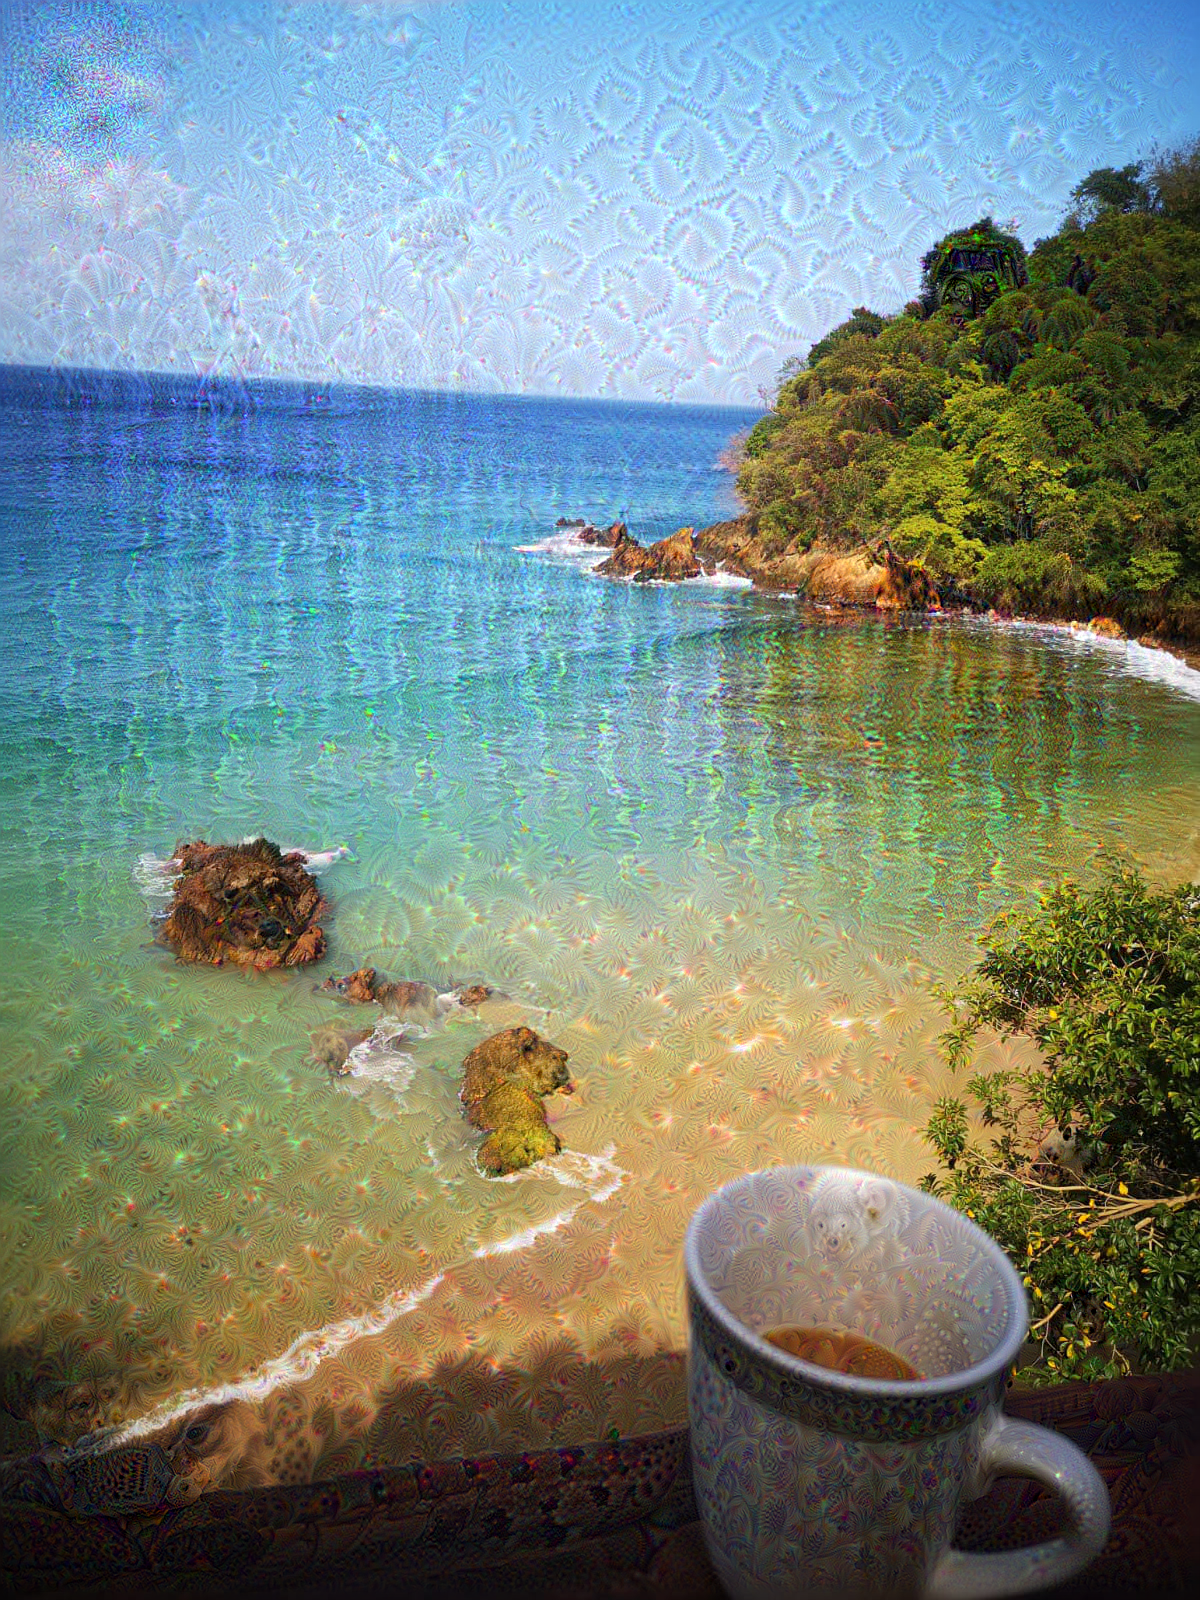

In [ ]:
display(Image(result_prefix + ".png"))